In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
directory = '/content/drive/MyDrive/potato disease_pred'

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
RGB_CHANNELS = 3
EPOCHS = 30

In [ ]:
## loading data using tensorflow keras preprocessing , it uplodes data in batch size
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for img_batch, label_batch in dataset.take(1):
  print(img_batch.shape)
  print(label_batch.numpy()) ## this will print the classes from the batch

(32, 256, 256, 3)
[0 1 0 1 0 0 2 1 1 0 1 0 0 1 1 0 1 2 0 1 1 1 0 0 1 1 2 1 1 1 1 1]


In [ ]:
for img_batch, label_batch in dataset.take(1):
  print(img_batch[0].numpy()) ## printing 3D vector of an image

[[[208. 203. 200.]
  [211. 206. 203.]
  [210. 205. 202.]
  ...
  [202. 197. 201.]
  [205. 200. 204.]
  [207. 202. 206.]]

 [[207. 202. 199.]
  [210. 205. 202.]
  [210. 205. 202.]
  ...
  [204. 199. 203.]
  [208. 203. 207.]
  [211. 206. 210.]]

 [[208. 203. 200.]
  [211. 206. 203.]
  [212. 207. 204.]
  ...
  [203. 198. 202.]
  [208. 203. 207.]
  [211. 206. 210.]]

 ...

 [[150. 141. 144.]
  [153. 144. 147.]
  [153. 144. 147.]
  ...
  [160. 151. 156.]
  [166. 157. 162.]
  [157. 148. 153.]]

 [[148. 139. 142.]
  [154. 145. 148.]
  [155. 146. 149.]
  ...
  [147. 138. 143.]
  [154. 145. 150.]
  [162. 153. 158.]]

 [[143. 134. 137.]
  [153. 144. 147.]
  [157. 148. 151.]
  ...
  [154. 145. 150.]
  [148. 139. 144.]
  [153. 144. 149.]]]


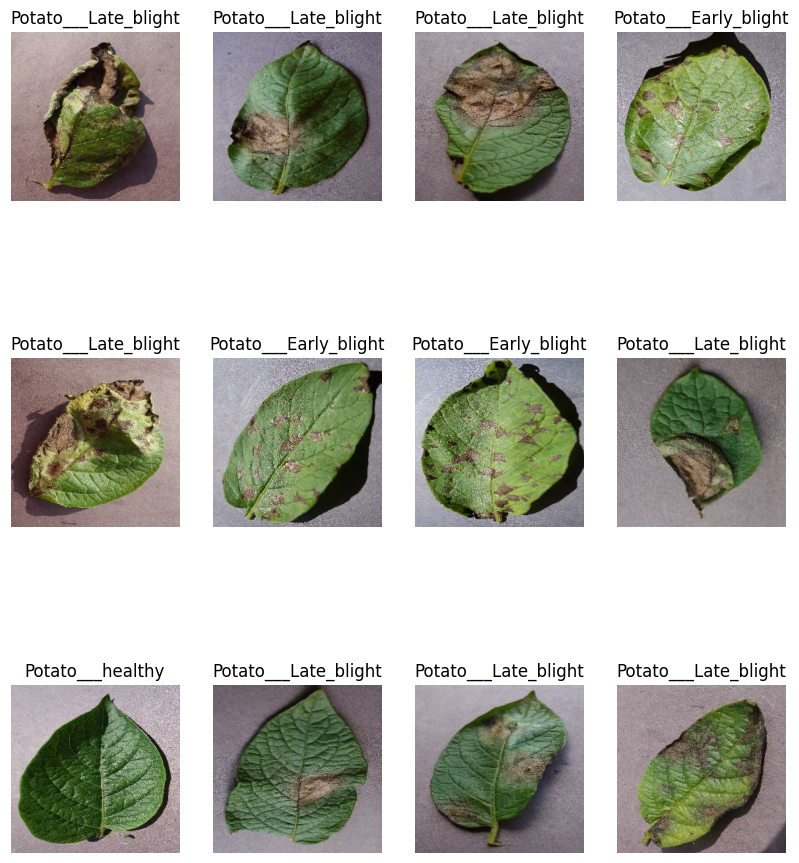

In [ ]:
## vizualizing the image
plt.figure(figsize=(10,12))
for img_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(img_batch[i].numpy().astype('uint8')) ## printing an image
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
len(dataset)
## ctual length of dataset is 68 * 32 = 2176 as our data is in batch of size 32

68

In [ ]:
# data split stratergy
#training ==>80%
#in remaining 20% , validation ==>10% and test ==>10%

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
## but here we can not use sklearn train_test split
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [ ]:
## so our 54 batches will be the train dataset
train_data = dataset.take(54)
len(train_data)

54

In [ ]:
## after 54 batches will be our validation and test dataset
remaining_data = dataset.skip(54)
len(remaining_data)

14

In [ ]:
## now splitting the remaining dataset in validation and test dataset
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_data = remaining_data.take(6)
len(val_data)

6

In [ ]:
test_data = remaining_data.skip(6)
len(test_data)

8

In [ ]:
## making a nice function for splitting data
def split_dataset_tf(ds,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed =12)

  train_sz = int(ds_size*train_size)
  val_sz = int(ds_size*val_size)

  train_ds = ds.take(train_sz)
  val_ds = ds.skip(train_sz).take(val_sz)
  test_ds = ds.skip(train_sz).skip(val_sz)

  return train_ds,val_ds,test_ds

In [ ]:
## clling the function to split the data
train_ds,val_ds,test_ds = split_dataset_tf(dataset)


In [ ]:
print('train_ds',len(train_ds))
print('val_ds',len(val_ds))
print('test_ds',len(test_ds))

train_ds 54
val_ds 6
test_ds 8


In [ ]:
### here cache and prefetch improves the performance of the pipeline
# in cache cpu loads the image and gpu trains on the image simultaneously
# in prefetch once u read the image for one epoch there is no need to read it again while performing second epoch

train_data = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#### preprocessing the image
## resizing and rescaling the image

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
### data augmentation for making model robust
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
### using convolutional neural network to build the model
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,RGB_CHANNELS)

n_classes = 3

model = models.Sequential([
    resize_and_rescale, ## addesd resize layer in the model
    data_augmentation,  ## added data augmentation layer in the model

    ## adding the convolutional layers
    layers.Conv2D(filters= 32,kernel_size = (3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(filters= 64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters= 64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters= 64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters= 64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters= 64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units = 64,activation='softmax'),

])

model.build(input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
## compiling the model
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
## training the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size =BATCH_SIZE,
    validation_data = val_data
)

Epoch 1/30
54/54 [==============================] - 636s 5s/step - loss: 1.2991 - accuracy: 0.4711 - val_loss: 0.8706 - val_accuracy: 0.5938
Epoch 2/30
54/54 [==============================] - 231s 4s/step - loss: 0.8534 - accuracy: 0.5689 - val_loss: 0.7344 - val_accuracy: 0.7188
Epoch 3/30
54/54 [==============================] - 238s 4s/step - loss: 0.6704 - accuracy: 0.7199 - val_loss: 0.6387 - val_accuracy: 0.7344
Epoch 4/30
54/54 [==============================] - 234s 4s/step - loss: 0.5081 - accuracy: 0.7922 - val_loss: 0.3962 - val_accuracy: 0.8021
Epoch 5/30
54/54 [==============================] - 247s 5s/step - loss: 0.3577 - accuracy: 0.8663 - val_loss: 0.2467 - val_accuracy: 0.9167
Epoch 6/30
54/54 [==============================] - 237s 4s/step - loss: 0.2845 - accuracy: 0.8872 - val_loss: 0.2213 - val_accuracy: 0.9323
Epoch 7/30
54/54 [==============================] - 234s 4s/step - loss: 0.2519 - accuracy: 0.9051 - val_loss: 0.1858 - val_accuracy: 0.9167
Epoch 8/30
54

In [ ]:
score = model.evaluate(test_data) ## evaluating the model on the test dataset

8/8 [==============================] - 19s 1s/step - loss: 0.2220 - accuracy: 0.9219


In [ ]:
score ## in this list first thing is the loss and second is the accuracy

[0.22195126116275787, 0.921875]

image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted labels:  Potato___Early_blight


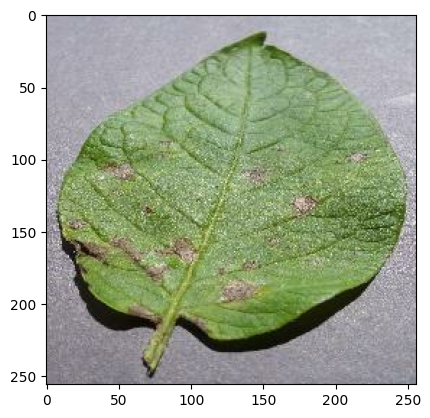

In [ ]:
## taking out predictions

import numpy as np
for img_batch, label_batch in test_data.take(1):

  first_img = img_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('image to predict')
  plt.imshow(first_img)
  print('actual label: ',class_names[first_label])

  batch_prediction= model.predict(img_batch)
  print('predicted labels: ', class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)  ## create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidance = round(100* (np.max(predictions[0])),2)

  return predicted_class, confidance

1/1 [==============================] - 0s 79ms/step


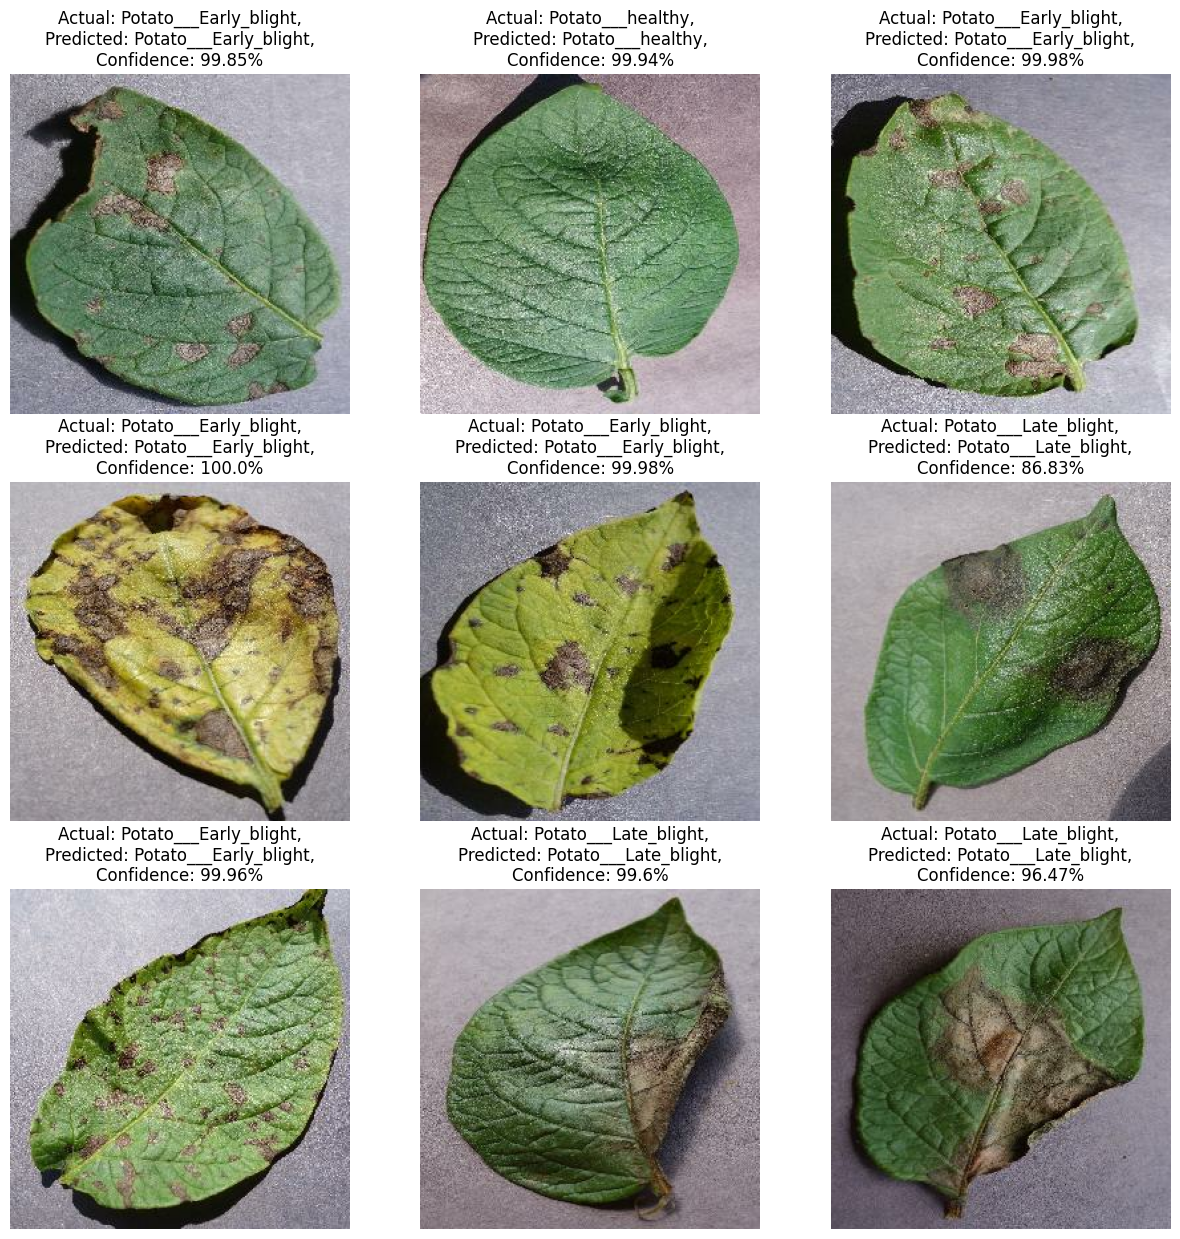

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in test_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f'Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%')
    plt.axis('off')

In [ ]:
import os
# Change to the desired directory in Google Drive
os.chdir('/content/drive/MyDrive/potato_disease_prediction')

In [ ]:
### saving the model
model_version = 1
model.save(f'{model_version}')